In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [29]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, maxlen, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post', maxlen=maxlen)

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs

In [30]:
uniqWords = pd.read_csv('dev-uniq.csv')
wlist = uniqWords.values.flatten().tolist()
wlist[1:5]

['नानुमन्यसे', 'सुदारुणालांकृतवेषधारिणा', 'शलभाः', 'गणित']

In [31]:
filter_object = filter(lambda x: x != " ", wlist)

without_empty_strings = list(filter_object)

print(len(wlist),len(without_empty_strings))

207180 207180


In [32]:
unph = pd.read_csv('devph.csv')
ph = unph.values.flatten().tolist()
ph[1:5]

['द्या', 'वा', 'ह्मॊ', 'प्ला']

In [33]:
#Build Char list to create char index
letters = set([])
ph[0][0]
#test = set(list(ph[0]))
#test
for i in range(len(ph)):
    if i%1000 == 0:
        print("Done:", i)
    letters = letters.union(set(ph[i]))
print(letters)

Done: 0
Done: 1000
Done: 2000
Done: 3000
Done: 4000
{'व', 'ठ', 'ु', 'य', 'र', 'ॊ', 'श', 'ॢ', 'ट', 'ख', 'स', 'आ', 'फ', 'ॄ', 'ई', 'त', 'ः', 'ज', 'ै', 'अ', 'थ', 'ि', 'क', 'े', 'द', 'ृ', 'औ', 'घ', 'ह', 'ध', 'ढ', 'छ', 'न', 'भ', 'ञ', 'ऋ', 'ल', 'इ', 'ओ', 'ऊ', 'ू', 'च', 'ग', 'ी', 'ौ', 'ङ', 'झ', 'ं', 'ँ', 'ण', 'उ', '्', 'ड', 'ष', 'प', 'ए', 'ा', 'म', 'ऽ', 'ऐ', 'ब', '-'}


In [34]:
char_to_int = dict((c, i) for i, c in enumerate(letters))
int_to_char = dict((i, c) for i, c in enumerate(letters))

In [35]:
#wlist+= ['सेल्व ', 'अलघन', 'नानु','थोमस', 'नीनु' ]
seqs_ds = pd.DataFrame(wlist)
encoded_seqs = encode_sequence_list(wlist,20)
# mix everything up
#np.random.shuffle(encoded_seqs)
print(wlist[10])
print(encoded_seqs[10])

पृष्टॊ
[54 25 53 51  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [36]:
encoded_seqs.shape

(207180, 20)

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
#X_train = scaled_seqs[:20000]
#X_test = scaled_seqs[20000:]
print(scaled_seqs[0])
scaled_seqs= np.reshape(scaled_seqs,(scaled_seqs.shape[0], scaled_seqs.shape[1], 1))
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(scaled_seqs, test_size=0.20, random_state=42)
scaled_seqs.shape

[0.83333333 0.36065574 0.85       0.25       0.85       0.
 0.93333333 0.53333333 0.03333333 0.28333333 0.85       0.56666667
 0.93333333 0.9        0.85       0.05       0.         0.
 0.         0.        ]


(207180, 20, 1)

In [64]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Masking
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] #features
encoding_dim = len(letters)
hidden_dim = int(encoding_dim / 2)

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(20,1))
#encoder = Masking(mask_value=0.0, input_shape=(input_dim, ))(input_layer)
encoder = LSTM(encoding_dim, return_sequences=True, activation='tanh',recurrent_dropout = 0)(input_layer)
#encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = LSTM(encoding_dim, return_sequences=True, activation='tanh',recurrent_dropout = 0)(decoder)
#decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [65]:
filename='sm_20_lettersdim.h5'
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=filename,
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2021-08-01 19:47:34.360233: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-01 19:47:34.360276: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-01 19:47:34.368132: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-01 19:47:34.368220: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/30
   9/1295 [..............................] - ETA: 33s - loss: 0.1586 - accuracy: 0.0014 

2021-08-01 19:47:35.948960: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-01 19:47:35.948997: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-01 19:47:35.955573: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-01 19:47:36.029773: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-01 19:47:36.032941: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-08-01 19:47:36.034348: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-01 19:47:36.035374: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_08_01_19_47_36
2

1295/1295 [==============================] - 15s 10ms/step - loss: 0.0274 - accuracy: 0.0113 - val_loss: 4.6465e-04 - val_accuracy: 2.4737e-04
Epoch 2/30
1295/1295 [==============================] - 13s 10ms/step - loss: 4.1266e-04 - accuracy: 1.1398e-05 - val_loss: 3.4157e-04 - val_accuracy: 0.0000e+00
Epoch 3/30
1295/1295 [==============================] - 13s 10ms/step - loss: 3.3266e-04 - accuracy: 0.0000e+00 - val_loss: 3.2382e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
1295/1295 [==============================] - 12s 9ms/step - loss: 3.2460e-04 - accuracy: 0.0000e+00 - val_loss: 3.2426e-04 - val_accuracy: 0.0000e+00
Epoch 5/30
1295/1295 [==============================] - 12s 9ms/step - loss: 3.1781e-04 - accuracy: 0.0000e+00 - val_loss: 3.1558e-04 - val_accuracy: 0.0000e+00
Epoch 6/30
1295/1295 [==============================] - 12s 9ms/step - loss: 3.1512e-04 - accuracy: 0.0000e+00 - val_loss: 3.1922e-04 - val_accuracy: 0.0000e+00
Epoch 7/30
1295/1295 [============================

KeyboardInterrupt: 

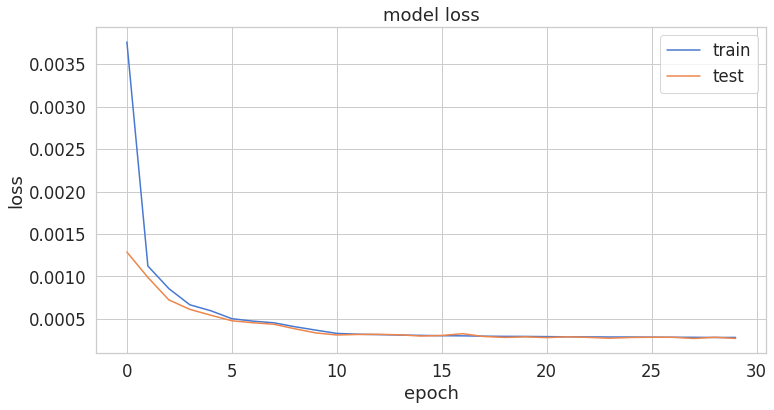

In [88]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [89]:
autoencoder = load_model(filename)
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.0002812697202898562


In [90]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.999)) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE: 0.0034151029906667966


In [91]:

#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0], 20)
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse

In [92]:
display(seqs_ds)


,0,MSE,MSE_Outlier
0,उक्त्वानुज्ञाप्य,0.001016,0
1,नानुमन्यसे,0.000175,0
2,सुदारुणालांकृतवेषधारिणा,0.004525,0
3,शलभाः,0.000026,0
4,गणित,0.000280,0
...,...,...,...
207175,नरकायेति,0.000041,0
207176,सर्वभूतानुकम्पकः,0.000310,0
207177,मातृवद,0.000031,0
207178,नर्मदायाम,0.000026,0


In [93]:

mse_threshold = np.quantile(seqs_ds['MSE'], 0.9999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.004718455450505615


In [94]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

In [95]:
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.loc[seqs_ds['MSE_Outlier'] == 1]

Num of MSE outlier:21


,0,MSE,MSE_Outlier
76,अन्यॊन्यवधकाङ्क्षिणाम,0.005579,1
2912,अन्यॊन्यवधकाङ्क्षिणॊः,0.005889,1
13701,बाष्पपूर्णाविलेक्षणाः,0.004758,1
21540,दरौणिवराङ्गभूषणम,0.004836,1
23535,सीतान्वेषणकाङ्क्षया,0.005377,1
30207,रामानिर्विण्णदर्शणाः,0.004824,1
65589,पुण्यलक्षणकर्माणं,0.004973,1
71289,रामलक्ष्मणलक्षणाः,0.004808,1
84674,ऊर्ध्वप्रणिहितेक्षणः,0.005242,1
105028,रॊषदॊषानुषङ्गेण,0.004761,1


In [96]:
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.loc[seqs_ds['MSE_Outlier'] == 1]

Num of MSE outlier:21


,0,MSE,MSE_Outlier
76,अन्यॊन्यवधकाङ्क्षिणाम,0.005579,1
2912,अन्यॊन्यवधकाङ्क्षिणॊः,0.005889,1
13701,बाष्पपूर्णाविलेक्षणाः,0.004758,1
21540,दरौणिवराङ्गभूषणम,0.004836,1
23535,सीतान्वेषणकाङ्क्षया,0.005377,1
30207,रामानिर्विण्णदर्शणाः,0.004824,1
65589,पुण्यलक्षणकर्माणं,0.004973,1
71289,रामलक्ष्मणलक्षणाः,0.004808,1
84674,ऊर्ध्वप्रणिहितेक्षणः,0.005242,1
105028,रॊषदॊषानुषङ्गेण,0.004761,1
